In [ ]:
# imports
import pandas as pd
import gensim.downloader as api
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
reviews = pd.read_csv('ryanair_reviews.csv')

In [ ]:
reviews.head()

,Unnamed: 0,Date Published,Overall Rating,Passenger Country,Trip_verified,Comment title,Comment,Aircraft,Type Of Traveller,Seat Type,...,Destination,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity
0,0,2024-02-03,10.0,United Kingdom,Not Verified,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,Boeing 737 900,Family Leisure,Economy Class,...,Luton,February 2024,4.0,5.0,3.0,4.0,4.0,yes,NaN,NaN
1,1,2024-01-26,10.0,United Kingdom,Trip Verified,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,NaN,Couple Leisure,Economy Class,...,Alicante,January 2024,3.0,5.0,3.0,5.0,5.0,yes,NaN,NaN
2,2,2024-01-20,10.0,United Kingdom,Trip Verified,“Really impressed!”,"Really impressed! You get what you pay for, th...",Boeing 737-800,Couple Leisure,Economy Class,...,Paris Beauvais,October 2023,5.0,5.0,4.0,5.0,5.0,yes,NaN,NaN
3,3,2024-01-07,6.0,United Kingdom,Trip Verified,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,Boeing 737,Solo Leisure,Economy Class,...,Liverpool,January 2024,3.0,2.0,1.0,3.0,3.0,yes,NaN,NaN
4,4,2024-01-06,10.0,Israel,Trip Verified,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",Boeing 737-800,Solo Leisure,Economy Class,...,Manchester,January 2024,4.0,5.0,NaN,4.0,5.0,yes,NaN,NaN


### Some ideas for analysis:
* sentiment analysis: analyze sentiments of each review, find how likely they are to recommend based on sentiment, find correlation between rating and sentiment, find percentage of positive sentiments vs. negative sentiments, see if comment title sentiments differ from their respective comment sentiments.

In [ ]:
w2v_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def extract_sentence_vector(sentence):
  """extracts sentence vector from word vectors via average word embeddings."""
  words = sentence.split()
  word_vectors = [w2v_model[word] for word in words if word in w2v_model]
  if not word_vectors:
      return None  # Return None if no word vectors are found
  sentence_vector = np.mean(word_vectors, axis=0)
  return sentence_vector

def similarity (x1, x2):
  # similarity is the opposite of distance
  return 1 - cosine(x1, x2)

In [ ]:
gen_sent1 = 'positive'
gen_sent2 = 'negative'

pos_vec = extract_sentence_vector(gen_sent1)
neg_vec = extract_sentence_vector(gen_sent2)

def predict_sentiment(sentence):
  """predicts whether sentence is positive or negative
  based on vectorization."""
  vec = extract_sentence_vector(sentence)

  if vec is None:
    return None

  sim1 = similarity(pos_vec, vec)
  sim2 = similarity(neg_vec, vec)

  if sim1 is None or sim2 is None:
    return None

  if sim1 > sim2:
    sentiment = 'positive'
  elif sim1 == sim2:
    sentiment = 'neutral'
  else:
    sentiment = 'negative'
  return sentiment

In [ ]:
# making a dictionary of predicted comment title sentiments
title_sentiments = {}

comment_titles = reviews['Comment title'].to_list()

for title in comment_titles:
  sentiment = predict_sentiment(title)
  if sentiment is not None:
    title_sentiments[title] = sentiment

In [ ]:
len(title_sentiments)

1445

In [ ]:
len(comment_titles)

2249

Something to note is the ~800 missing rows because it couldn't find any sentence vectors

In [ ]:
# making a dictionary of predicted comment sentiments
comment_sentiments = {}

comments = reviews['Comment'].to_list()

for comment in comments:
  sentiment = predict_sentiment(comment)
  if sentiment is not None:
    comment_sentiments[comment] = sentiment

In [ ]:
print(len(comment_sentiments), len(comments))

2249 2249


this one is better, has a full list

In [ ]:
# making df for sentiments
sentiment_df = pd.DataFrame({'Comment title': reviews['Comment title'].to_list()})

title_sent_df = pd.DataFrame({'Comment title': list(title_sentiments.keys()),
                              'Title sentiment': list(title_sentiments.values())})
# merge
sentiment_df = title_sent_df.merge(sentiment_df, on='Comment title', how='right')

# add comment column
sentiment_df['Comment'] = reviews['Comment'].to_list()

comment_sent_df = pd.DataFrame({'Comment': list(comment_sentiments.keys()),
                                'Comment sentiment': list(comment_sentiments.values())})

sentiment_df = sentiment_df.merge(comment_sent_df, on='Comment', how='left')

sentiment_df['Type of Traveller'] = reviews['Type Of Traveller']
sentiment_df['Seat Type'] = reviews['Seat Type']
sentiment_df['Recommended'] = reviews['Recommended']

In [ ]:
sentiment_df

,Comment title,Title sentiment,Comment,Comment sentiment,Type of Traveller,Seat Type,Recommended
0,"""bang on time and smooth flights""",positive,Flew back from Faro to London Luton Friday 2nd...,positive,Family Leisure,Economy Class,yes
1,"""Another good affordable flight""",positive,Another good affordable flight with Ryanair. O...,positive,Couple Leisure,Economy Class,yes
2,“Really impressed!”,NaN,"Really impressed! You get what you pay for, th...",positive,Couple Leisure,Economy Class,yes
3,“a decent offering from Ryanair”,positive,I should like to review my flight from Faro to...,positive,Solo Leisure,Economy Class,yes
4,“cabin crew were welcoming and friendly”,positive,"Flight left the gate ahead of schedule, fare w...",positive,Solo Leisure,Economy Class,yes
...,...,...,...,...,...,...,...
2244,Ryanair customer review,negative,Myself and my daughter took a holiday to Kos. ...,positive,NaN,Economy Class,no
2245,Ryanair customer review,negative,Stansted to Pula. Tried to adhere to all rules...,negative,NaN,Economy Class,no
2246,Ryanair customer review,negative,When printing the boarding tickets we got our ...,positive,NaN,Economy Class,no
2247,Ryanair customer review,negative,Budapest - Manchester and back again with a 5 ...,positive,NaN,Economy Class,no


Okay so now we have a title sentiment and comment sentiment columns with some other columns we can compare for analysis.

In [ ]:
# check how many columns have a different sentiment for title and comment
print(f"Positive title but negative comment: {len(sentiment_df.loc[(sentiment_df['Title sentiment'] == 'positive') & (sentiment_df['Comment sentiment'] == 'negative')])}")
print(f"Negative title but positive comment: {len(sentiment_df.loc[(sentiment_df['Title sentiment'] == 'negative') & (sentiment_df['Comment sentiment'] == 'positive')])}")

Positive title but negative comment: 174
Negative title but positive comment: 934


This could likely be due to it perceiving "Ryanair customer review" as negative. Maybe we can change them to neutral?

In [ ]:
# manually changing ryanair customer review to neutral
sentiment_df.loc[(sentiment_df['Comment title'] == 'Ryanair customer review'), 'Title sentiment'] = 'neutral'

In [ ]:
sentiment_df

,Comment title,Title sentiment,Comment,Comment sentiment,Type of Traveller,Seat Type,Recommended
0,"""bang on time and smooth flights""",positive,Flew back from Faro to London Luton Friday 2nd...,positive,Family Leisure,Economy Class,yes
1,"""Another good affordable flight""",positive,Another good affordable flight with Ryanair. O...,positive,Couple Leisure,Economy Class,yes
2,“Really impressed!”,NaN,"Really impressed! You get what you pay for, th...",positive,Couple Leisure,Economy Class,yes
3,“a decent offering from Ryanair”,positive,I should like to review my flight from Faro to...,positive,Solo Leisure,Economy Class,yes
4,“cabin crew were welcoming and friendly”,positive,"Flight left the gate ahead of schedule, fare w...",positive,Solo Leisure,Economy Class,yes
...,...,...,...,...,...,...,...
2244,Ryanair customer review,neutral,Myself and my daughter took a holiday to Kos. ...,positive,NaN,Economy Class,no
2245,Ryanair customer review,neutral,Stansted to Pula. Tried to adhere to all rules...,negative,NaN,Economy Class,no
2246,Ryanair customer review,neutral,When printing the boarding tickets we got our ...,positive,NaN,Economy Class,no
2247,Ryanair customer review,neutral,Budapest - Manchester and back again with a 5 ...,positive,NaN,Economy Class,no


In [ ]:
# trying again
print(f"Positive title but negative comment: {len(sentiment_df.loc[(sentiment_df['Title sentiment'] == 'positive') & (sentiment_df['Comment sentiment'] == 'negative')])}")
print(f"Negative title but positive comment: {len(sentiment_df.loc[(sentiment_df['Title sentiment'] == 'negative') & (sentiment_df['Comment sentiment'] == 'positive')])}")

Positive title but negative comment: 174
Negative title but positive comment: 399


This seems much more normal.

(-1.0999995346993452,
 1.099999977842826,
 -1.0999984885736542,
 1.0999911514461922)

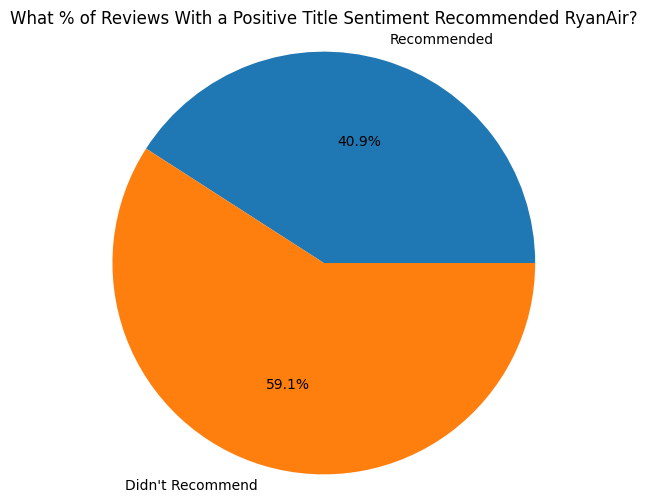

In [ ]:
# how likely is someone to recommend based on positive comment title?
positive_yes_count = sentiment_df[(sentiment_df['Title sentiment'] == 'positive') & (sentiment_df['Recommended'] == 'yes')].shape[0]
positive_no_count = sentiment_df[(sentiment_df['Title sentiment'] == 'positive') & (sentiment_df['Recommended'] == 'no')].shape[0]

labels = ["Recommended", "Didn't Recommend"]

plt.figure(figsize=(6,6))
plt.pie([positive_yes_count, positive_no_count], labels=labels, autopct='%1.1f%%')
plt.title('What % of Reviews With a Positive Title Sentiment Recommended RyanAir?')
plt.axis('equal')

(-1.0999997445479348,
 1.099999987835616,
 -1.099998934551953,
 1.0999937839180665)

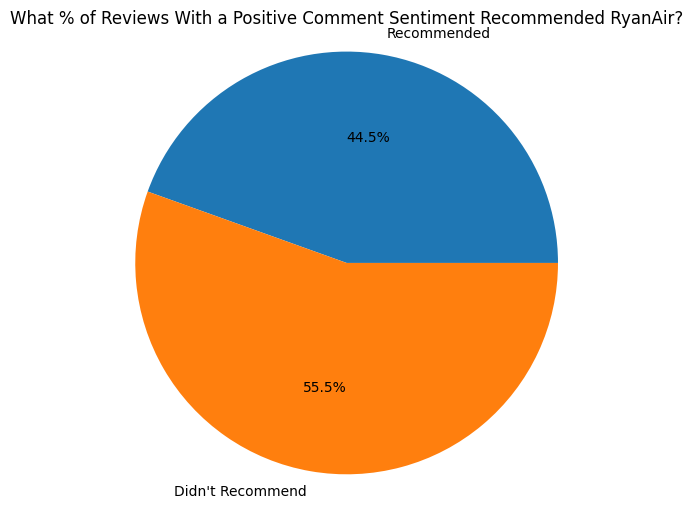

In [ ]:
# how likely is someone to recommend based on positive comment?
positive_yes_count = sentiment_df[(sentiment_df['Comment sentiment'] == 'positive') & (sentiment_df['Recommended'] == 'yes')].shape[0]
positive_no_count = sentiment_df[(sentiment_df['Comment sentiment'] == 'positive') & (sentiment_df['Recommended'] == 'no')].shape[0]

labels = ["Recommended", "Didn't Recommend"]

plt.figure(figsize=(6,6))
plt.pie([positive_yes_count, positive_no_count], labels=labels, autopct='%1.1f%%')
plt.title('What % of Reviews With a Positive Comment Sentiment Recommended RyanAir?')
plt.axis('equal')

(-1.099999999190262,
 1.0999999999614412,
 -1.0999999997704133,
 1.0999999974654597)

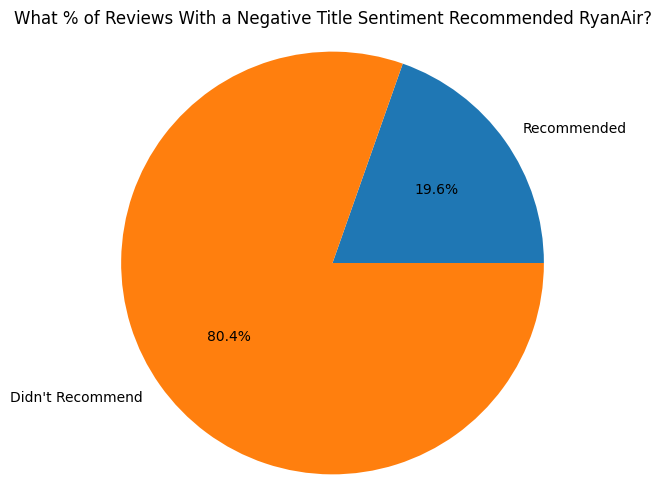

In [ ]:
# what about negative sentiments?
negative_yes_count = sentiment_df[(sentiment_df['Title sentiment'] == 'negative') & (sentiment_df['Recommended'] == 'yes')].shape[0]
negative_no_count = sentiment_df[(sentiment_df['Title sentiment'] == 'negative') & (sentiment_df['Recommended'] == 'no')].shape[0]

labels = ["Recommended", "Didn't Recommend"]

plt.figure(figsize=(6,6))
plt.pie([negative_yes_count, negative_no_count], labels=labels, autopct='%1.1f%%')
plt.title('What % of Reviews With a Negative Title Sentiment Recommended RyanAir?')
plt.axis('equal')

(-1.0999999577202377,
 1.099999997986678,
 -1.0999999877353712,
 1.0999999148655986)

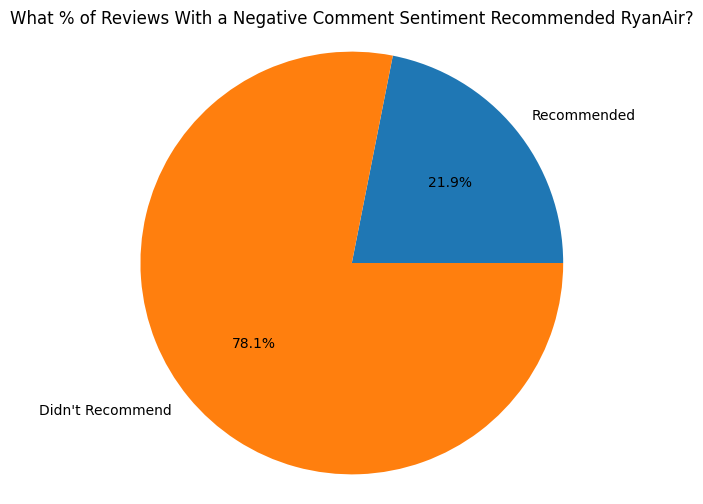

In [ ]:
negative_yes_count = sentiment_df[(sentiment_df['Comment sentiment'] == 'negative') & (sentiment_df['Recommended'] == 'yes')].shape[0]
negative_no_count = sentiment_df[(sentiment_df['Comment sentiment'] == 'negative') & (sentiment_df['Recommended'] == 'no')].shape[0]

labels = ["Recommended", "Didn't Recommend"]

plt.figure(figsize=(6,6))
plt.pie([negative_yes_count, negative_no_count], labels=labels, autopct='%1.1f%%')
plt.title('What % of Reviews With a Negative Comment Sentiment Recommended RyanAir?')
plt.axis('equal')

In [ ]:
# % of reviews with pos comment based on seat type
econ_pos_pct = round((sentiment_df.loc[(sentiment_df['Seat Type'] == 'Economy Class')
                      & (sentiment_df['Comment sentiment'] == 'positive')].shape[0]
                      / sentiment_df.loc[sentiment_df['Seat Type'] == 'Economy Class'].shape[0]) * 100, 2)

prem_pos_pct = round((sentiment_df.loc[(sentiment_df['Seat Type'] == 'Premium Economy')
                      & (sentiment_df['Comment sentiment'] == 'positive')].shape[0]
                      / sentiment_df.loc[sentiment_df['Seat Type'] == 'Premium Economy'].shape[0]) * 100, 2)

biz_pos_pct = round((sentiment_df.loc[(sentiment_df['Seat Type'] == 'Business Class')
                     & (sentiment_df['Comment sentiment'] == 'positive')].shape[0]
                     / sentiment_df.loc[sentiment_df['Seat Type'] == 'Business Class'].shape[0]) * 100, 2)

first_pos_pct = round((sentiment_df.loc[(sentiment_df['Seat Type'] == 'First Class')
                       & (sentiment_df['Comment sentiment'] == 'positive')].shape[0]
                       / sentiment_df.loc[sentiment_df['Seat Type'] == 'First Class'].shape[0]) * 100, 2)

Text(0, 0.5, 'Percentage of Positive Comments')

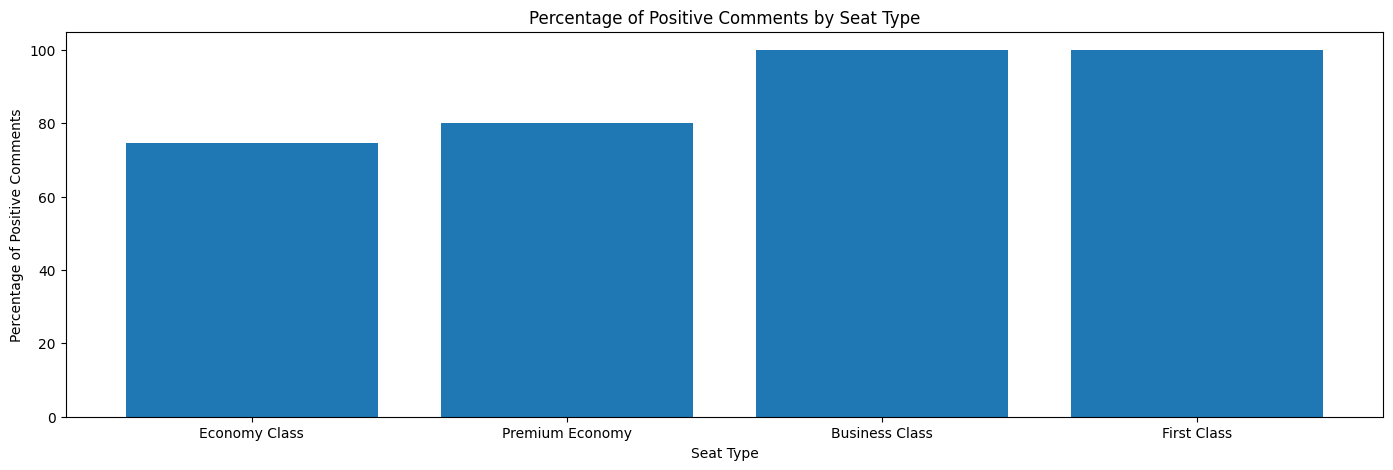

In [ ]:
# make bar chart of percentages
plt.figure(figsize=(17,5))
labels = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
plt.bar(labels, [econ_pos_pct, prem_pos_pct, biz_pos_pct, first_pos_pct])
plt.title('Percentage of Positive Comments by Seat Type')
plt.xlabel('Seat Type')
plt.ylabel('Percentage of Positive Comments')

### stuff we need to do:
* divide data into 80-20% train-test split for ML models. ✅
* construct SVM and logisitic regression models to determine recommended and compare accuracy to determine which is better (use sample code from labs) ✅
* explain these models and training processes
* Use classification_report from scikit-learn to show the consolidated classification_report
* Perform error analysis, share anecdotal examples showing where the model succeeds and fails. Share qualitative analysis of the results.

## Divide data into 80-20% train-test split and initialize ML models

In [ ]:
# drop all duplicates and NaNs
sentiment_df = sentiment_df.drop_duplicates()
sentiment_df = sentiment_df.dropna()

# create dfs of features and labels
sentiment_features_df = sentiment_df.iloc[:,:-1]
sentiment_labels_df = sentiment_df[["Recommended"]]

sentiment_features_df.head()

,Comment title,Title sentiment,Comment,Comment sentiment,Type of Traveller,Seat Type
0,"""bang on time and smooth flights""",positive,Flew back from Faro to London Luton Friday 2nd...,positive,Family Leisure,Economy Class
1,"""Another good affordable flight""",positive,Another good affordable flight with Ryanair. O...,positive,Couple Leisure,Economy Class
3,“a decent offering from Ryanair”,positive,I should like to review my flight from Faro to...,positive,Solo Leisure,Economy Class
4,“cabin crew were welcoming and friendly”,positive,"Flight left the gate ahead of schedule, fare w...",positive,Solo Leisure,Economy Class
5,"""close online checkin 3 hours before""",positive,Booked a fight from Copenhagen to Poland thoug...,positive,Solo Leisure,Economy Class


In [ ]:
sentiment_labels_df.head()

,Recommended
0,yes
1,yes
3,yes
4,yes
5,no


So to make the text data work we should vectorize

In [ ]:
# convert labels to binary
sentiment_labels_df['Recommended'] = sentiment_labels_df['Recommended'].map({'yes': 1, 'no': 0})

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(sentiment_features_df, sentiment_labels_df, test_size=0.2, random_state=42)

# create vectorizer to vectorize features
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['Comment title'] +
                                       ' ' + X_train['Comment'] +
                                       ' ' + X_train['Type of Traveller'] +
                                       ' ' + X_train['Seat Type'])
X_test_vec = vectorizer.transform(X_test['Comment title'] +
                                  ' ' + X_test['Comment'] +
                                  ' ' + X_test['Type of Traveller'] +
                                  ' ' + X_test['Seat Type'])

# convert y_train and y_test to numpy arrays
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

<ipython-input-89-37f4cecd1bce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_labels_df['Recommended'] = sentiment_labels_df['Recommended'].map({'yes': 1, 'no': 0})


In [ ]:
def train_and_evaluate_classifier(classifier, X_train, y_actual, X_test, y_test_actual):
  classifier.fit(X_train, y_actual)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test_actual, y_pred)
  return accuracy

Ok now we test models

In [ ]:
classifier = LogisticRegression(max_iter=1000)
accuracy = train_and_evaluate_classifier(classifier, X_train_vec, y_train, X_test_vec, y_test)
print (f"Accuracy of Logistic Regression = {accuracy*100}%")

Accuracy of Logistic Regression = 89.45686900958466%


In [ ]:
classifier = SVC(kernel="linear")
accuracy = train_and_evaluate_classifier(classifier, X_train_vec, y_train, X_test_vec, y_test)
print (f"Accuracy of Support Vector Classificaiton = {accuracy*100}%")

Accuracy of Support Vector Classificaiton = 89.1373801916933%


In [ ]:
classifier = MLPClassifier(random_state=1, max_iter=300)
accuracy = train_and_evaluate_classifier(classifier, X_train_vec, y_train, X_test_vec, y_test)
print (f"Accuracy of Support Vector Classificaiton = {accuracy*100}%")

Accuracy of Support Vector Classificaiton = 92.01277955271566%


All three models are very accurate but MLP Classifier is far and away the most accurate at 92%

## Explaining Models and Processes

## Use classification_report from scikit-learn to show the consolidated classification_report

## Perform Error Analysis